In [1]:
import os
import json
import torch
import pickle
import numpy as np
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cuda:0


In [6]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 1.8 MB/s eta 0:00:0000:0100:01
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ijpuu202
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ijpuu202
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=a85bddd7576421df8d4a47f3fc8b23242e57635de767b5b996199985ebfe00c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6uyuun0/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


## Load the data from RefCOCOg

Here we load the annotation file with all the references and the images. 

In [4]:
with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))



{
    "image_id": 9,
    "split": "train",
    "sentences": [
        {
            "tokens": [
                "a",
                "yellow",
                "rectangle",
                "bowl",
                "with",
                "broccoli",
                "and",
                "a",
                "brown",
                "food",
                "in",
                "it"
            ],
            "raw": "a yellow rectangle bowl with broccoli and a brown food in it",
            "sent_id": 92713,
            "sent": "a yellow rectangle bowl with broccoli and a brown food in it"
        },
        {
            "tokens": [
                "the",
                "tray",
                "that",
                "holds",
                "the",
                "broccoli"
            ],
            "raw": "The tray that holds the broccoli.",
            "sent_id": 92714,
            "sent": "the tray that holds the broccoli"
        }
    ],
    "file_name": "COCO_train2014_00000000

Here the data loader class.

In [2]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("../extractCOCO/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
# load the train dataset
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


Functions wich perform the blurring.

The carrots toward the front of the picture.
./refcocog/images/COCO_train2014_000000564050.jpg
[142.39, 239.66, 262.82, 169.65]


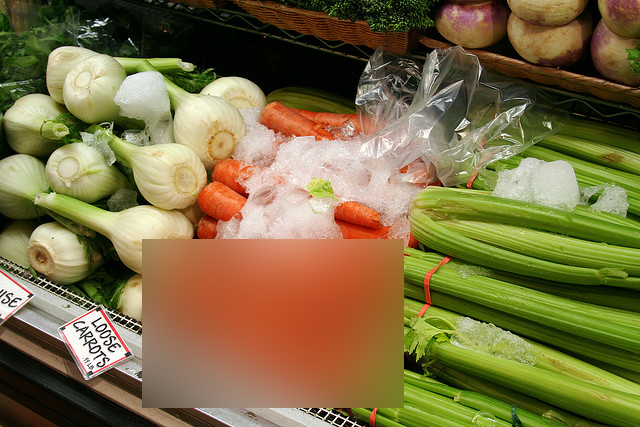

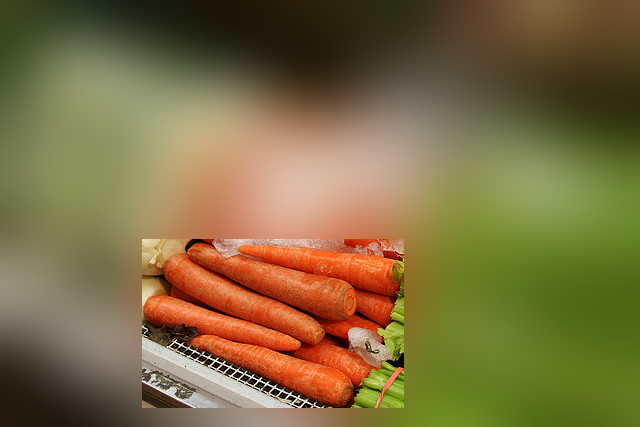

In [9]:
def blur_out(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)


def blur_in(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

sample = train_dataset[500]
print(sample["caption"])
print(sample["file_name"])
print(sample["bbox"])

# extract the image
img = Image.open('../extractCOCO/'+sample["file_name"][1:])
blur_in(img, sample["bbox"]).show()
blur_out(img, sample["bbox"]).show()


### Extracting the boxes with DETR

Here we would like to extract the bounding boxes with DETR. Then, we will use the bounding boxes to get the blur in and blur out images.

In [11]:
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform, device):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    # assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def blur_out_detr(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)


def blur_in_detr(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

In [17]:
# load a batch of 10 images
N_images = 10
Images = [Image.open('../extractCOCO/'+sample["file_name"][1:]) for sample in train_dataset[:N_images]]

# load the model from the torch hub
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)


import time

start = time.time()
detected = [detect(im, model, transform) for im in Images]
end = time.time()
print(f'time to detect the boxes in {N_images} images: ',round(end - start,2))

Using cache found in /home/rickbook/.cache/torch/hub/facebookresearch_detr_main
/home/rickbook/mambaforge/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rickbook/mambaforge/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


time to detect the boxes in 10 images:  12.67


In [21]:
detected[0][1] # boxes

tensor([[ 4.6029e+02,  4.2057e+02,  4.9583e+02,  4.6014e+02],
        [ 3.7039e+02, -4.0584e-02,  6.3897e+02,  4.7234e+02],
        [ 3.7416e+02,  1.9335e-01,  6.3921e+02,  3.1532e+02],
        [ 1.3490e+02,  3.8163e+01,  3.0226e+02,  2.2404e+02],
        [ 2.5998e+02,  4.2397e+02,  3.6310e+02,  4.7938e+02],
        [ 1.0431e+02,  2.4136e+02,  2.1610e+02,  3.6930e+02],
        [ 1.1624e+00,  4.1860e+01,  2.4171e+02,  4.6847e+02],
        [ 1.6375e+02,  1.1533e+02,  2.0001e+02,  1.5014e+02],
        [ 1.3370e+02,  1.3567e+02,  6.0765e+02,  4.7326e+02],
        [ 2.2306e+02,  1.7141e+02,  2.9197e+02,  2.5029e+02],
        [ 4.6069e+02,  4.1766e+02,  4.9648e+02,  4.5854e+02],
        [ 3.7550e+02,  2.0853e-01,  6.3915e+02,  3.1921e+02],
        [ 2.0008e+02,  2.1500e+02,  5.4499e+02,  4.5120e+02]])

In [103]:
# get the blurred images
import time
start = time.time()
batch_blur_out_in = [
        [(blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist()))
            for idx in range(len(d[1]))]
                for I, d in zip(Images, detected)     
        ]
end = time.time()
print(f'time to blur the images in {N_images} images: ',round(end - start,2))

time to blur the images in 10 images:  3.08


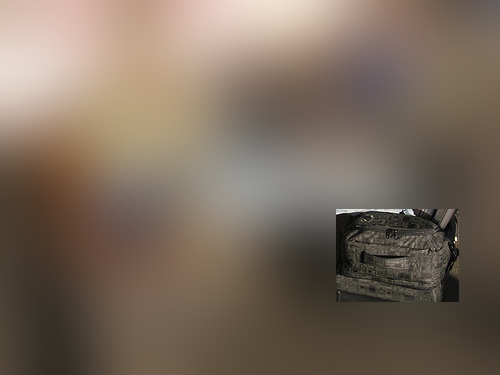

In [70]:
batch_blur_out_in[9][2][0]

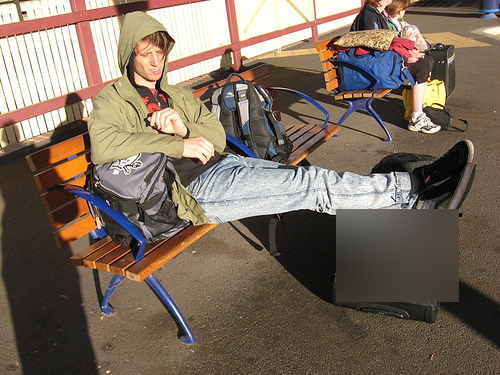

In [71]:
batch_blur_out_in[9][2][1]

In [82]:

import clip
import torch

# https://github.com/baaivision/EVA/tree/master/EVA-CLIP
# https://huggingface.co/QuanSun/EVA-CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("RN50", device=device)

import time
start = time.time()
# compute directly the images 
batch_blur_out_in = [
        [   
            
            torch.stack([preprocess(i).unsqueeze(0) 
                for i in [blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist())]]).squeeze(1)
                for idx in range(len(d[1]))]
                for I, d in zip(Images, detected)     
        ]
end = time.time()
print(f'time to preprocess the images in {N_images} images: ',round(end - start,2))

time to preprocess the images in 10 images:  4.79


In [97]:

# store all the images blurd out and in
# in two separate lists
blur_outin = [  
    
    [torch.stack([i[0] for i in img]), # blur out 
    torch.stack([i[1] for i in img])] # blurd in
    
    for img in batch_blur_out_in]

# list of all the images blurd out
# for image 0
blur_outin[0][0].shape
# (n_boxes, 3, 224, 224)
# torch.Size([13, 3, 224, 224])

torch.Size([13, 3, 224, 224])

In [106]:
text = clip.tokenize([train_dataset[9]["caption"]]).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(blur_outin[9][0])
    text_features = clip_model.encode_text(text)

    logits_per_image, logits_per_text = clip_model(blur_outin[9][0], text)
    probs = logits_per_text.softmax(dim=-1).cpu().numpy().round(3)

print("Label probs:", probs)

Label probs: [[0.    0.    0.    0.    0.    0.001 0.    0.    0.578 0.035 0.358 0.001
  0.008 0.017 0.    0.   ]]


Label caption: Park bench the man is sitting on.


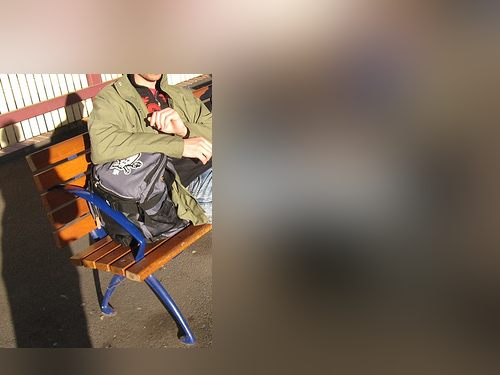

In [108]:
print("Label caption:", train_dataset[9]["caption"])

batch_blur_outin = [
        [(blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist()))
            for idx in range(len(d[1]))]
                for I, d in zip(Images, detected)     
        ]

# image 0, box 8
batch_blur_outin[9][8][0]

### Functions to preprocess 

Here I am willing to preprocess the data, to avoid redundant computations during the training. With the data preprocessed we straightfowardly train the model without preprocess the data during the training.

In [52]:
import clip
import torch
import time
# source: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb#scrollTo=Y6Jrz6xz71C0
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# https://github.com/baaivision/EVA/tree/master/EVA-CLIP
# https://huggingface.co/QuanSun/EVA-CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

# load the model from the torch hub
clip_model, preprocess = clip.load("RN50", device=device)
detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True).cuda()


#####################################################

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#####################################################

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

#####################################################

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

#####################################################

def detect(im, model, transform, device):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    # assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5
    # keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)
    return probas[keep], bboxes_scaled

#####################################################

def blur_out_detr(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)

#####################################################

def blur_in_detr(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(image))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_max)
    x_1, x_2 = int(x_min), int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

#####################################################

def get_img_blur_outin(Images, detected):
    """ Return a list of tuple of pillow images
    [[(blur_out, blur_in),...],[...]] 
    Dimensions of the list:
        dim_1: number of images
        dim_2: number of boxes found by detr
    Args:
        


    """
    return [[(blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist()))
                for idx in range(len(d[1]))]
                    for I, d in zip(Images, detected)]

#####################################################

def get_img_blur_outin_preprocessed(Images, detected):
    """Return a list of tuple of pillow images preprocessed
    with CLIP preprocessor

    Args:
        Images (list): list of pillow images
        detected (list): list of detected boxes with detr

    Returns:
        _list_: list of preprocessed images blur_out, blur_in
    """
    return [[torch.stack([preprocess(i).unsqueeze(0) 
                for i in [blur_out_detr(I, d[1][idx].tolist()),blur_in_detr(I, d[1][idx].tolist())]]).squeeze(1)
                for idx in range(len(d[1]))]
                for I, d in zip(Images, detected)]

#####################################################

def get_listed_img_blur_outin(Images, detected):
    """ Return the list of list with the boxex
    blurd in, blurd out.

    example:
        [   
           [
            [list of img with box blurd out],
            [list of img with box blurd in]
           ],
           [
            [list of img with box blurd out],
            [list of img with box blurd in]
           ],
           ...
        ]
    Args:
        Images (list): list of pillow images
        detected (list): list of detected boxes with detr

    Returns:
        _list_: list of list of images blur_out, blur_in
    
    """
    
    return [[torch.stack([i[0] for i in img]), # blur out 
            torch.stack([i[1] for i in img])] # blurd in
                for img in get_img_blur_outin_preprocessed(Images, detected)]

#####################################################

def get_prob_clip(clip, clip_model, samples_json, blur_outin, offset, device):
    
    probabilities = []
    for idx, sample in enumerate(blur_outin):
        text = clip.tokenize([samples_json[idx+offset]["caption"]]).to(device)

        # to do not keep track of the computational
        # graph to compute the gradients
        with torch.no_grad():
            _, logits_per_text_blur_out = clip_model(sample[0].to(device), text)
            _, logits_per_text_blur_in = clip_model(sample[1].to(device), text)
            probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).type(torch.float16)
            probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).type(torch.float16)
            probs = torch.stack([probs_blur_out, probs_blur_in])
        probabilities.append(probs.squeeze(1))

    return probabilities

#####################################################




# load a batch of 10 images
N_images = 100

start = time.time()
# load the images
Images = [Image.open('../extractCOCO/'+sample["file_name"][1:]) for sample in train_dataset[:N_images]]
end = time.time()
print(f'time to load {N_images} images: ',round(end - start,2))

start = time.time()
# detect the boxes
detected = [detect(im, detr, transform, device) for im in Images]
# get the boxes
boxes = [d[1].type(torch.float16) for d in detected]
end = time.time()
print(f'time to detect the boxes in {N_images} images: ',round(end - start,2))


blur_outin = get_listed_img_blur_outin(Images, detected)


Using device: cuda


Using cache found in /home/rickbook/.cache/torch/hub/facebookresearch_detr_main


time to load 100 images:  0.0
time to detect the boxes in 100 images:  8.77


Compute the probabilities with clip with the images blurred out and in.

In [57]:
def get_prob_clip(clip, clip_model, samples_json, blur_outin, offset, device):
    
    probabilities = []
    for idx, sample in enumerate(blur_outin):
        text = clip.tokenize([samples_json[idx+offset]["caption"]]).to(device)

        # to do not keep track of the computational
        # graph to compute the gradients
        with torch.no_grad():
            _, logits_per_text_blur_out = clip_model(sample[0].to(device), text)
            _, logits_per_text_blur_in = clip_model(sample[1].to(device), text)
            probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
            probs = np.stack([probs_blur_out, probs_blur_in])
        probabilities.append(probs.squeeze(1))

    return probabilities

# get training data

start = time.time()
probabilities = get_prob_clip(clip, clip_model, train_dataset, blur_outin, 0, device)
end = time.time()
print(f'time to get the probabilities in {N_images} images: ',round(end - start,2))

time to get the probabilities in 100 images:  5.97


In [65]:
print('number of images:', len(probabilities))
print('shape: (blur_out_in, number of boxes for each image 0) :', probabilities[0].shape)


number of images: 100
shape: (blur_out_in, number of boxes for each image 0) : (2, 16)


Here I combine the probabilities with the respective bounding box.

In [86]:
def get_prob_box(probabilities, boxes):
    prob_box = []

    for p, b in zip(probabilities, boxes):
        # print(torch.from_numpy(p).shape,b.cpu().permute(1,0).shape)
        # print(torch.concat([torch.from_numpy(p),b.cpu().permute(1,0)],0).permute(1,0).shape)

        # to get the boxes in the refCOCO format
        # x_min, y_min, x_max-x_min, y_max-y_min
        b[:,2] = b[:,2] - b[:,0]
        b[:,3] = b[:,3] - b[:,1]
        
        # concat the boxes and the probabilities
        prob_box.append(torch.concat([torch.from_numpy(p),b.cpu().permute(1,0)],0).permute(1,0))
    return prob_box

start = time.time()
prob_box = get_prob_box(probabilities, boxes)
end = time.time()
print(f'time to match the prob with boxes with {N_images} images: ',round(end - start,2))


print('number of images:', len(prob_box))
print('shape: (number of boxes for each image 0, blur_out_in probability clip + boxes) :', prob_box[0].shape)

time to match the prob with boxes with 100 images:  0.09
number of images: 100
shape: (number of boxes for each image 0, blur_out_in probability clip + boxes) : torch.Size([16, 6])


In [91]:
prob_box[0][:3,:] # first 3 boxes of the image 0 with the probabilities

tensor([[5.0020e-04, 3.2898e-02, 9.8875e+01, 2.4038e+02, 1.1962e+02, 1.2712e+02],
        [1.0002e-04, 1.9104e-02, 4.6225e+02, 4.2125e+02, 3.1750e+01, 3.7250e+01],
        [2.9993e-04, 6.9702e-02, 3.9250e+02, 3.5575e+02, 2.0450e+02, 1.2100e+02]],
       dtype=torch.float16)

In [46]:

n_samples = 99

text = clip.tokenize([train_dataset[n_samples]["caption"]]).to(device)

# to do not keep track of the computational
# graph to compute the gradients
with torch.no_grad():
    _, logits_per_text_blur_out = clip_model(blur_outin[n_samples][0].to(device), text)
    _, logits_per_text_blur_in = clip_model(blur_outin[n_samples][0].to(device), text)
    probs_blur_out = logits_per_text_blur_out.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
    probs_blur_in = logits_per_text_blur_in.softmax(dim=-1).cpu().numpy().round(4).astype(np.float16)
    probs = np.stack([probs_blur_out, probs_blur_in])

probs.squeeze(1)

array([[0.3416, 0.658 ],
       [0.3416, 0.658 ]], dtype=float16)

In [41]:
train_dataset[n_samples]["caption"]

'The elephant behind the other one'

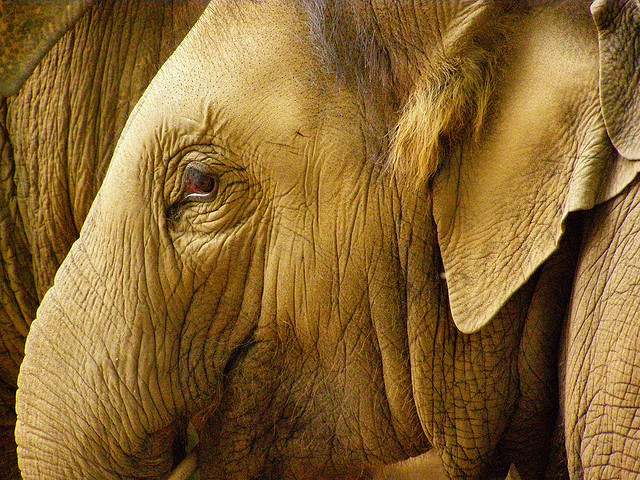

In [42]:
Images[n_samples]

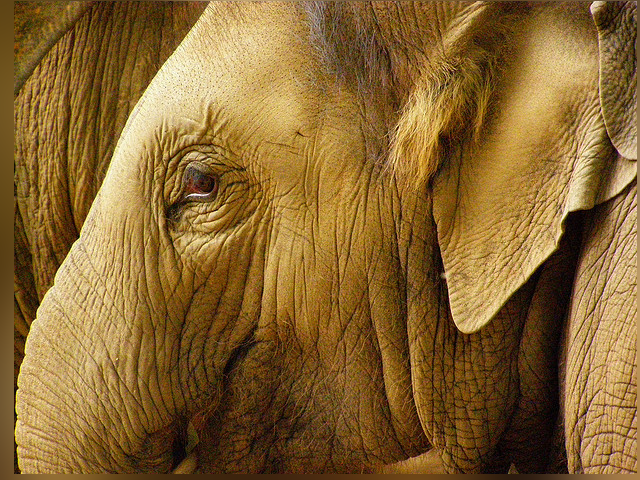

In [40]:
examples = get_img_blur_outin(Images, detected)
examples[99][1][0].show()

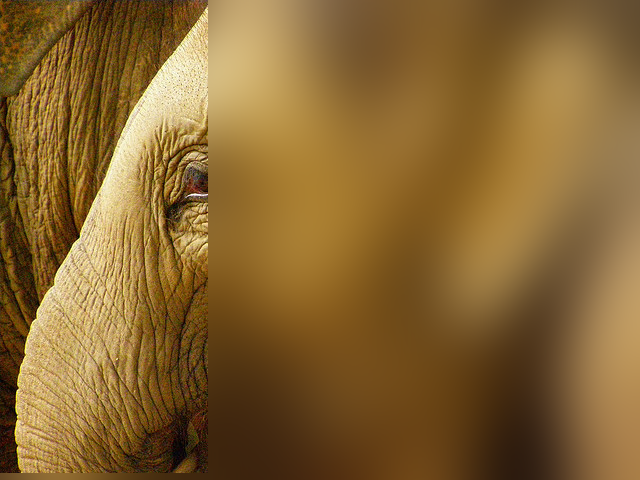

In [44]:
examples[99][0][0].show()